## Machine Learning - Random Forest Classifier Example
### Kevin Jaggs Jan 2020

### Objective:

Train a Random Forest Classifier (RFC) algorithm to an input training database. Starting with a default parameter RFC model, the aim is to tune hyperparameters and identify the most important input features to optimise the classifier performance.

Outcomes at each stage will be scored using conventional binary classification scoring metrics.


### Method:

* Step 1 -  [Import the required python modules](#section_id_import_modules). Import of pandas dataframe, numpy, matplotlib and sklearn modules


* Step 2 -  [User selected parameters](#section_id_parameters). Options for user to select scoring criteria, cross validation number etc.


* Step 3 -  [Import Database_csv_to_pandas](#section_id_import_database). Import of database csv file to pandas dataframe. Note: the csv file is an independently formatted file, composed of random scoring criteria and the output column in last position [-1].


* Step 4 -  [Split dataset into test and train portions](#section_id_test_train_split). For conventional machine learning workflows, the input and output datasets are divided into training and testing sub-volumes. Algorithms are trained on the (not suprisingly) 'train' dataset and model outcomes are compared using the 'test' dataset, to prevent over-fitting.


* Step 5 -  [Train default Random Forest Classifier](#section_id_default_rfc). SKlearn RFC trained using default parameters only.


* Step 6 -  [Perform randomised search with cross validation.](#section_id_randomised_search). A random search of a large grid of hyperparameters highlights the model parameter values where a targeted GridSearchCV should be performed. 


* Step 7 - [Review randomised search model](#section_id_randomised_search_evaluation) Evaluate the Randomised search model performance using a classification report and confusion matrix.


* Step 8 - [Perform GridsearchCV to fine tune hyperparameters.](#section_id_gridsearchcv)Using the RandomizedSearchCV output as a guide, identify the hyperparameter values to optimise model performance.


* Step 9 - [GridsearchCV model evaluation.](#section_id_gridsearchcv_evaluation) Evaluate the final GridsearchCV hyperparameter selection model using a classification report and confusion matrix.


* Step 10- [Feature selection](#section_id_gridsearchcv_evaluation) Determine the most important features using the SelectFromModel module. Features that score above a predetermined threshold score are identified.


* Step 11- [Print important features](#section_id_gridsearchcv_print_features) Selected features are ordered by descending score. High number = high importance.


* Step 12- [Evaluate feature selection model](#section_id_features_evaluation) Evaluate the feature selection model performance using a classification report and confusion matrix.


* Step 13- [ROC Plot](#section_id_roc) Comparison of the ROC curves for raw, GridsearchCV and feature selection result models. Labels show the AUC score.


* Step 14- [Precision vs Recall Plot](#section_id_pr) Comparison of the PR curves for raw, GridsearchCV and feature selection result models. Labels show the AUPR score.


* Step 15- [Compare model performances](#section_id_model_summary) Compare the outputs from all stages of the model evaluation: raw, RandomizedSearch, GridsearchCV and feature selection.


### Dataset
A synthetic dataset with a binary outcome [0,1] in the last position. Most columns are discrete values [0,1,2,3,4,5] but some are continuous floats.
Note: the supplied input file is a conditioned, synthetic binary classification dataset i.e binary outcome of 0 or 1. You can simply add in a user selected database with the following preconditions: 1) Nan or empty cell values will be replaced with zero, 2) binary outcome only, 3) the results column is the last one [-1]. 

### Programming
This evaluation is performed using Python code and SKlearn provides all the classifier modules. 

At the time of script creation the following verions were used.
Python: 3.7.6
Numpy: 1.18.1
Pandas: 1.0.1
SKlearn: 0.22.1

### Outputs
Overview plot of model fit for each classifier
Sheet of evaluation criteria ordered by descending AUC score

<a id='section_id_import_modules'></a>

### 1. Import required Python Modules

In [130]:
#print(__doc__)

#pandas dataframe - similar to a python version of excel. Most efficient way to perform data operations
import pandas as pd

#numpy for most mathematical operations
import numpy as np

#matplotlib for plotting functions
#import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
#seaborn for plotting heatmap
#import seaborn as sns

#sklearn for machine learning modules and scoring algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#SKlearn classifier and hyperparameter search modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, plot_confusion_matrix,classification_report
from sklearn.metrics import roc_curve,roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix,classification_report

#chi2 calculation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import scipy

#feature selection
from sklearn.feature_selection import SelectFromModel

#plotting
import matplotlib.pyplot as plt


import sys
import sklearn
print("Python version: ", sys.version_info[0],".",sys.version_info[1],".",sys.version_info[2])
print("Numpy Version: " ,np.__version__)
print("Pandas Version: " ,pd.__version__)
print("Scikitlearn Version: " ,sklearn.__version__)



Python version:  3 . 7 . 6
Numpy Version:  1.18.1
Pandas Version:  1.0.1
Scikitlearn Version:  0.22.1


<a id='section_id_parameter'></a>

### 2. User selected parameters
Select scoring method, options of 'accuracy', 'precision', 'f1', 'roc_auc'
Crossvalidation fold i.e how many subsets the training data is split into for cross validation purposes, recommend value above 3 as this below this point overfits the data and will create a prediction error in the final assessment.

In [131]:
#Accuracy - ratio of correctly predicted observation to the total observations. 
#Accuracy works best if false positives and false negatives have similar cost. 
#Accuracy = TP+TN/TP+FP+FN+TN

#Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
#High precision relates to the low false positive rate.
#Precision = TP/TP+FP

#Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class
#Recall = TP/TP+FN

#F1 score - F1 Score is the weighted average of Precision and Recall. Takes both false pos and false neg into account. 
#Use F1 if you have an uneven class distribution. 
#If the cost of false positives and false negatives are very different - look at both Precision and Recall.
#F1 Score = 2*(Recall * Precision) / (Recall + Precision)

#roc_auc - the area under the receiver operating characteristic, plots the False Positive rate vs True Positive Rate for different thrshold cut offs.
#The best models should plot towards the upper left quadrant of the plot, therefore calculating the area under the curve is a good measure of model performance.


#score_cat = 'roc_auc'
score_cat = 'accuracy'
#score_cat = 'precision'
#score_cat = 'f1_score'

#plot labels are updated based upon 
if score_cat == 'roc_auc':
    plot_label = 'AUC'
if score_cat == 'accuracy':
    plot_label = 'Accuracy'
if score_cat == 'precision':
    plot_label = 'Precision' 
if score_cat == 'recall':
    plot_label = 'Recall'    
if score_cat == 'f1_score':
    plot_label = 'f1 score'  
    
#number of folds (equal data subsets) employed in cross validation - recommended to use above 4 for this dataset    
cross_validation_fold = 5    

#confidnce interval for chi2 calculation
conf_int = 0.95

#see random number generators - for repeatability
random_seed = 57


<a id='section_id_import_database'></a>

### 3. Import database csv file to pandas
The csv file is imported into a pandas dataframe, allowing ease of computation in later modules. All columns are considered numeric. The column header is the data category and the index is the row ID. There should be no Nan or empty cell values amd the output column is assumed to be in last column position.

In [132]:
def readcsvfile():
    '''
    (csv)->(pandas dataframe)
    routine to read import csv file to pandas
    comma separation, column headers = first row of text
    All column data is considered numeric
    Index = row 
    -999.25 values are converted to numpy NaN
    PRECONDITION: Import csv file is the correct format. All lines without a 1/0 output removed.
    KJAGGS June 2020
    '''
    
    #read csv file to pandas dataframe
    df = pd.read_csv('classification_dataset.csv', encoding = 'utf-8',header=0,sep=',', index_col=0)
    #df = df.set_index('Row ID')
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df.replace(-999.25,np.NaN)
    df = df.replace(np.NaN,0)
    #print(df.isnull().any())
    return df

df = readcsvfile()

###optional qc features - remove hash/# to view 
#print(df.head)
#print(df.columns.tolist)


print("Dataframe size on import")
print("Number of prospects :", df.shape[0])
print("Number of data categories :", df.shape[1])

Dataframe size on import
Number of prospects : 352
Number of data categories : 43


<a id='section_id_test_train_split'></a>

### 4. Split into test and train datasets
Data is divided into test and training sub-volumes for the purpose of fitting models and preventing over-fitting/bias issues. The current defaults in the module below are to split 80:20 train:test. No random number seeding, no shuffling of input data and no stratifying (equal proportions of success/fail  outcomes in each sub-volume). These features are adjusted at the bottom of the next cell as the input to function; user can change accordingly.

In [133]:
def training_split(Xdata, Ydata, test_size=0.2,stratify=None,random_state=None,shuffle=False):
    '''
    (DataframeXColumns)(DataframeYColumn)=>(array)(array)(array)(array)
    For the purposes of splitting x and y data into test and training sets
    train_test_split is currently set to default settings
    PRECONDITION: Input datasets are formatted correctly
    KJAGGS June2020
    '''

    #split the data - default settings for now
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=test_size,stratify=stratify, random_state = random_state, shuffle = shuffle)

    #resize the output data sets if a 1 column vector, now compatible  with regression modules
    if len(X_train.shape) <2:  
       X_train = X_train.ravel()
    if len(y_train.shape) <2:  
       y_train = y_train.ravel()
    if len(X_test.shape) <2:  
       X_test = X_test.ravel()
    if len(y_train.shape) <2:  
       y_test = y_test.ravel()
    
    return X_train, X_test, y_train, y_test

#print(df.columns.tolist())
#output dataset is success/fail only
print(df.shape)

#remove result column from input dataset
y = df[df.columns[-1]]

#X = df.drop(df.columns[[-1]], axis=1)
#X = df.drop(df.columns[[1,-1]], axis=1)
X = df.drop(df.columns[[0,1,-1]], axis=1)



#split the datasets
#Shuffle = randomly shuffle the data before, If shuffle=False then stratify must be None.
#random state = seeding of random numbers for reproducibility across various modules
#stratify = ensure proportion of outcomes are the same across both datasets i.e % of successes in train = % of successes in test
X_train, X_test, y_train, y_test = training_split(X,y,shuffle=True,random_state=random_seed,stratify=y,test_size=0.25)

print("Train and test dataset sizes")
print("Training dataset size :", X_train.shape)
print("Test dataset size :", X_test.shape)

(352, 43)
Train and test dataset sizes
Training dataset size : (264, 40)
Test dataset size : (88, 40)


<a id='section_id_default_rfc'></a>

### 5. Train default parameter Random Forest Classifer
Using only the default parameters the SKlearn RFC is fitted to the input training dataset and performance is reviewed using a classification report and confusion matrix. Model outputs are saved for further comparison later.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest%20classifier#sklearn.ensemble.RandomForestClassifier

              precision    recall  f1-score   support

           0       0.71      0.61      0.66        41
           1       0.70      0.79      0.74        47

    accuracy                           0.70        88
   macro avg       0.71      0.70      0.70        88
weighted avg       0.71      0.70      0.70        88

Default model  AUC score:  0.7189932537623248


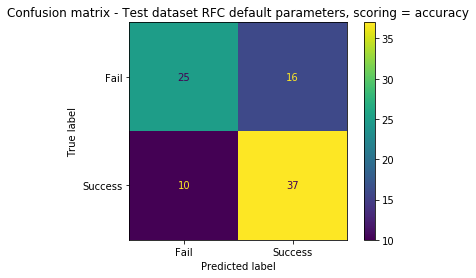

In [134]:
#Create a default random forest Classifier
clf_raw = RandomForestClassifier(random_state=random_seed)

#Train the model using the training sets
clf_raw.fit(X_train, y_train)

#Predict the response for test dataset
#_raw suffix is used to identify this model in the final model reviews
y_pred_raw = clf_raw.predict(X_test)

#y_score_raw = clf_raw.predict_proba(X_test_scaled)
#retains positive values only
y_score_raw = clf_raw.predict_proba(X_test)[:,1]

#print("Accuracy =", accuracy_score(y_test, y_pred_raw))
#print("Precision =", precision_score(y_test, y_pred_raw))
#print('f1 = {:.2f}'.format(f1_score(y_test, y_pred_raw)))
#print("AUC =", roc_auc_score(y_test, y_pred_raw))

# print classification report 
print(classification_report(y_test, y_pred_raw)) 

#confusion matrix plot
disp = plot_confusion_matrix(clf_raw,X_test,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - Test dataset RFC default parameters, scoring = ' + score_cat)

#print(title)
#print(disp.confusion_matrix)

print("Default model  AUC score: ", roc_auc_score( y_test, y_score_raw))


<a id='section_id_randomised_search'></a>

### 6. Perform randomised search with cross validation.
Randomly selecting from a large grid of hyperparameters, the RandomizedSearchCV provides a quick way to highlight value regions for detailed hyperparameter selection. The results from this tuning process will inform a more targeted parameter range selection later on during GridSearchCV.
Default Cross Validation fold of 3 remains to keep run time down.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [135]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 80, num = 40)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(2, 20, num = 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(2, 20, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation.
clf_rs = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=random_seed, n_jobs = -1)
# Fit the random search model
clf_rs.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

<a id='section_id_randomised_search_evaluation'></a>

### 7. Review randomised search model
Evaluate the Randomised search model performance using a classification report and confusion matrix.

              precision    recall  f1-score   support

           0       0.67      0.54      0.59        41
           1       0.65      0.77      0.71        47

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.65        88

Random search  AUC score:  0.7524649714582251


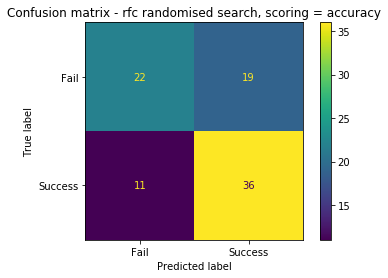

In [136]:
#Predict the response for test dataset
#_rs suffix is used to identify this model as rondomised search
y_pred_rs = clf_rs.predict(X_test)

#retains positive values only
y_score_rs = clf_rs.predict_proba(X_test)[:,1]

# print classification report 
print(classification_report(y_test, y_pred_rs)) 

#confusion matrix plot
disp = plot_confusion_matrix(clf_rs,X_test,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - rfc randomised search, scoring = ' + score_cat)

print("Random search  AUC score: ", roc_auc_score( y_test, y_score_rs))

<a id='section_id_gridsearchcv'></a>

### 8. Perform GridsearchCV to fine tune hyperparameters.
Using the RandomizedSearchCV output as a guide, identify the hyperparameter values to optimise model performance.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [137]:
print("RandomizedSearch best parameters:")
print(clf_rs.best_params_)

print("RandomizedSearch hyperparaneter grid:")
print(random_grid)

RandomizedSearch best parameters:
{'n_estimators': 400, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 28, 'bootstrap': False}
RandomizedSearch hyperparaneter grid:
{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, None], 'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'bootstrap': [True, False]}


In [146]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'n_estimators': [1650,1700,1750],
    'max_depth': [None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [9, 10,11],
    'min_samples_split': [5,6,7],
}
# Create a based model
rf_cv = RandomForestClassifier(random_state= random_seed)
# Instantiate the grid search model
clf_cv = GridSearchCV(estimator = rf_cv, param_grid = param_grid, 
                          cv = cross_validation_fold, n_jobs = -1, verbose = 2)

clf_cv.fit(X_train, y_train)



Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  5.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=57,
                                  

<a id='section_id_gridsearchcv_evaluation'></a>

###  9. GridsearchCV model evaluation.
Evaluate the final GridsearchCV hyperparameter selection model using a classification report and confusion matrix.

Gridsearchcv best parameters:
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1750}
              precision    recall  f1-score   support

           0       0.69      0.61      0.65        41
           1       0.69      0.77      0.73        47

    accuracy                           0.69        88
   macro avg       0.69      0.69      0.69        88
weighted avg       0.69      0.69      0.69        88

GridsearchCV  AUC score:  0.7623248572911262


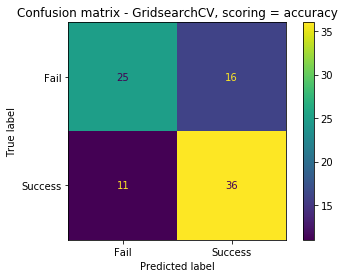

In [147]:
print("Gridsearchcv best parameters:")
print(clf_cv.best_params_)

#Predict the response for test dataset
#_rs suffix is used to identify this model as rondomised search
y_pred_cv = clf_cv.predict(X_test)

#retains positive values only
y_score_cv = clf_cv.predict_proba(X_test)[:,1]

# print classification report 
print(classification_report(y_test, y_pred_cv)) 

#confusion matrix plot
disp = plot_confusion_matrix(clf_cv,X_test,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - GridsearchCV, scoring = ' + score_cat)

print("GridsearchCV  AUC score: ", roc_auc_score( y_test, y_score_cv))


<a id='section_id_feature_selection'></a>

###  10. Feature selection using SKlearn SelectFromModel.
Determine the most important features using the SelectFromModel module. 
Features that score above a predetermined threshold score are identified.

In [148]:
#fit a new RFC using the best gridsearch parameters
clf_sfm = RandomForestClassifier(**clf_cv.best_params_,random_state=random_seed)

# determine the threshold that features must exceed to be determined important
sfm = SelectFromModel(clf_sfm, threshold=0.02)

# Train the selector
sfm.fit(X_train, y_train)

#reduce the train and test sets to the selected features only
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

#fit a new RFC using the best gridsearch parameters
clf_fs = RandomForestClassifier(**clf_cv.best_params_,random_state= random_seed)

#fit the model using the training sets, new model required to 
clf_fs.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1750,
                       n_jobs=None, oob_score=False, random_state=57, verbose=0,
                       warm_start=False)

<a id='section_id_print_features'></a>

###  11. Print the best features.
Selected features are ordered in descending score. High number = high importance.

In [149]:
#print(clf_fs.estimators_)

fs_labels = []

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    #print(feature_labels[feature_list_index])
    fs_labels.append(feature_labels[feature_list_index])

# get importance
importance = clf_fs.feature_importances_.tolist()    
 
res = sorted(zip(fs_labels, importance), key = lambda x: x[1], reverse=True)     
    
for i,v in enumerate(res):    
    print('Feature: %0s, Score: %.5f' % (v[0],v[1]))
    #print(v)
    

Feature: HC caused IG anomaly?, Score: 0.22931
Feature: Flat Spot, Score: 0.16135
Feature: Consistency within mapped target area, Score: 0.13382
Feature: Downdip conformance, Score: 0.08604
Feature: Amplitude and frequency shadow, Score: 0.07458
Feature: Excluding possible stacked pays, is the AVO , Score: 0.04797
Feature: Anomalies outside closure, Score: 0.04710
Feature: Soft Lithology, Score: 0.04308
Feature: Change in AVO compared to model, Score: 0.04265
Feature: Tuning Effects, Score: 0.04066
Feature: Lateral conformance, Score: 0.04043
Feature: Late trap preservation, Score: 0.02785
Feature: Amplitude change, Score: 0.02514


<a id='section_id_features_evaluation'></a>

### 12. Evaluate feature selection model.
Evaluate the feature selection model performance using a classification report and confusion matrix.

              precision    recall  f1-score   support

           0       0.69      0.61      0.65        41
           1       0.69      0.77      0.73        47

    accuracy                           0.69        88
   macro avg       0.69      0.69      0.69        88
weighted avg       0.69      0.69      0.69        88

SFM feature selection AUC score:  0.7415672029060716


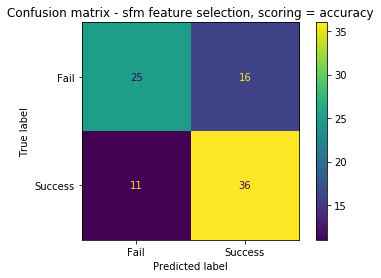

In [150]:
#Predict the response for test dataset
#_rs suffix is used to identify this model as rondomised search
y_pred_fs = clf_fs.predict(X_important_test)

#retains positive values only
y_score_fs = clf_fs.predict_proba(X_important_test)[:,1]

# print classification report 
print(classification_report(y_test, y_pred_fs)) 

#confusion matrix plot
disp = plot_confusion_matrix(clf_fs,X_important_test,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - sfm feature selection, scoring = ' + score_cat)

print("SFM feature selection AUC score: ", roc_auc_score( y_test, y_score_fs))

<a id='section_id_roc'></a>

### 13. ROC Plot
Comparison of the ROC curves for raw, GridsearchCV and feature selection result models. Labels show the AUC score.

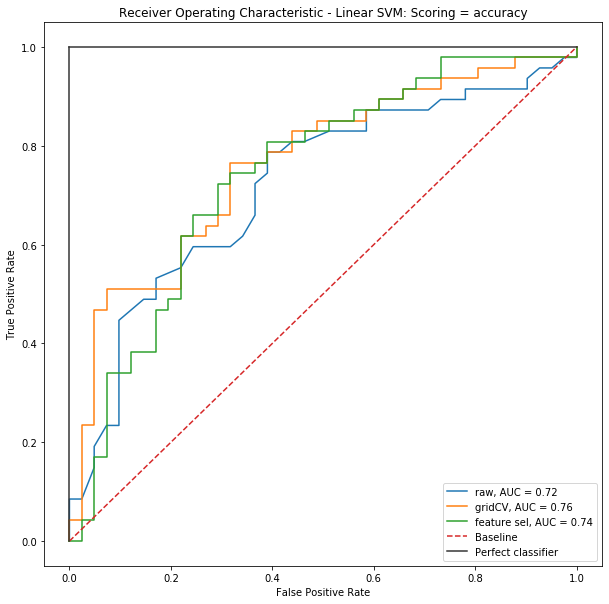

In [151]:
#ROC AUC Curve Generation for final optimised model
false_positive_raw, true_positive_raw, threshold_raw = roc_curve(y_test, y_score_raw)

#ROC AUC Curve Generation for final optimised model
false_positive_gridcv, true_positive_gridcv, threshold_tuned_feature = roc_curve(y_test, y_score_cv)

#ROC AUC Curve Generation for faeture selection model
false_positive_fs, true_positive_fs, threshold_fs = roc_curve(y_test, y_score_fs)

#ROC AUC Curve Generation for final optimised model
#false_positive_chi2, true_positive_chi2, threshold_chi2 = roc_curve(y_test, y_score_chi2)

raw_auc_label = "raw, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_raw))
gridcv_auc_label = "gridCV, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_cv))
fs_auc_label = "feature sel, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_fs))
#chi2_auc_label = "chi2, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_chi2))

#Plot ROC Curve
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Linear SVM: Scoring = ' + score_cat)
plt.plot(false_positive_raw, true_positive_raw, label=raw_auc_label)
plt.plot(false_positive_gridcv, true_positive_gridcv, label=gridcv_auc_label)
plt.plot(false_positive_fs, true_positive_fs,label=fs_auc_label)
#plt.plot(false_positive_chi2, true_positive_chi2,label=chi2_auc_label)
plt.plot([0, 1], ls="--", label='Baseline')
plt.plot([0, 0], [1, 0] , c=".2"), plt.plot([1, 1] , c=".2",label="Perfect classifier")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

#print('roc_auc_score for Linear SVM: ', roc_auc_score(y_test, y_score_tuned_feature))

<a id='section_id_pr'></a>

### 14. Precision vs Recall Plot
Comparison of the PR curves for raw, GridsearchCV and feature selection result models. Labels show the AUPR score.


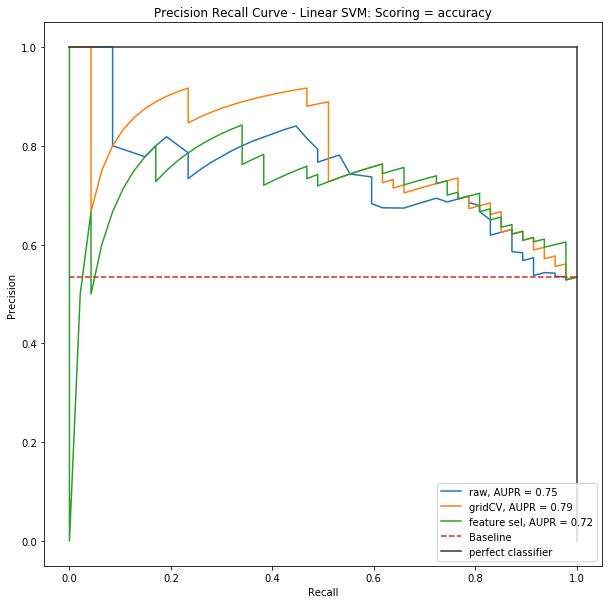

In [152]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


#AUPR Curve Generation for raw model
prec_raw, recall_raw, threshold_pr_raw = precision_recall_curve(y_test, y_score_raw)

#AUPR Curve Generation for gridsearch cv model
prec_gridcv, recall_gridcv, threshold_pr_tuned_feature = precision_recall_curve(y_test, y_score_cv)

#AUPR Curve Generation for final optimised model
prec_fs, recall_fs, threshold_pr_fs = precision_recall_curve(y_test, y_score_fs)

#AUPR Curve Generation for final optimised model
#prec_chi2, recall_chi2, threshold_pr_chi2 = precision_recall_curve(y_test, y_score_chi2)

raw_pr_label = "raw, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_raw))
gridcv_pr_label = "gridCV, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_cv))
fs_pr_label = "feature sel, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_fs))
#chi2_pr_label = "rfe, Chi2 = {:.2f}".format(average_precision_score(y_test, y_score_chi2))

baseline = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve


#Plot Precision Recall Curve
plt.subplots(1, figsize=(10,10))
plt.title('Precision Recall Curve - Linear SVM: Scoring = ' + score_cat)
plt.plot( recall_raw,prec_raw, label=raw_pr_label)
plt.plot( recall_gridcv,prec_gridcv, label=gridcv_pr_label)
plt.plot( recall_fs,prec_fs,label=fs_pr_label)
#plt.plot( recall_chi2,prec_chi2,label=chi2_pr_label)
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.plot([0, 1], [1, 1] , c=".2"), plt.plot([1, 1] , [1, 0], c=".2",label="perfect classifier")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc="lower right")
plt.show()

<a id='section_id_model_summary'></a>

### 15. Compare model performances.
Compare the outputs from all stages of the model evaluation: raw, RandomizedSearch, GridsearchCV and feature selection.

In [153]:
def summary_scores(y_test_summary, y_pred_summary, y_score_summary):
    
    print('Accuracy score on test set: {:.2f}'.format(accuracy_score(y_test_summary, y_pred_summary)))
    print('Precision score on test set: {:.2f}'.format(precision_score(y_test_summary, y_pred_summary)))
    print('Recall score on test set: {:.2f}'.format(recall_score(y_test_summary, y_pred_summary)))
    print('Micro f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='micro')))
    print('Macro f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='macro')))
    print('Weighted f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='weighted')))
    print("AUC  on test set: {:.2f}".format(roc_auc_score(y_test_summary, y_score_summary)))
    print("\n")

print("\nRandom Forest Classifier: Default parameters\n")    
summary_scores(y_test, y_pred_raw, y_score_raw)

print("Random Forest Classifier:  RanomizedSearch\n")
summary_scores(y_test, y_pred_rs, y_score_rs)

print("Random Forest Classifier:  GridsearchCV\n")
summary_scores(y_test, y_pred_cv, y_score_cv)


print("Random Forest Classifier:  Feature Selection\n")
summary_scores(y_test, y_pred_fs, y_score_fs)


Random Forest Classifier: Default parameters

Accuracy score on test set: 0.70
Precision score on test set: 0.70
Recall score on test set: 0.79
Micro f1  score on test set: 0.70
Macro f1  score on test set: 0.70
Weighted f1  score on test set: 0.70
AUC  on test set: 0.72


Random Forest Classifier:  RanomizedSearch

Accuracy score on test set: 0.66
Precision score on test set: 0.65
Recall score on test set: 0.77
Micro f1  score on test set: 0.66
Macro f1  score on test set: 0.65
Weighted f1  score on test set: 0.65
AUC  on test set: 0.75


Random Forest Classifier:  GridsearchCV

Accuracy score on test set: 0.69
Precision score on test set: 0.69
Recall score on test set: 0.77
Micro f1  score on test set: 0.69
Macro f1  score on test set: 0.69
Weighted f1  score on test set: 0.69
AUC  on test set: 0.76


Random Forest Classifier:  Feature Selection

Accuracy score on test set: 0.69
Precision score on test set: 0.69
Recall score on test set: 0.77
Micro f1  score on test set: 0.69
Macro 